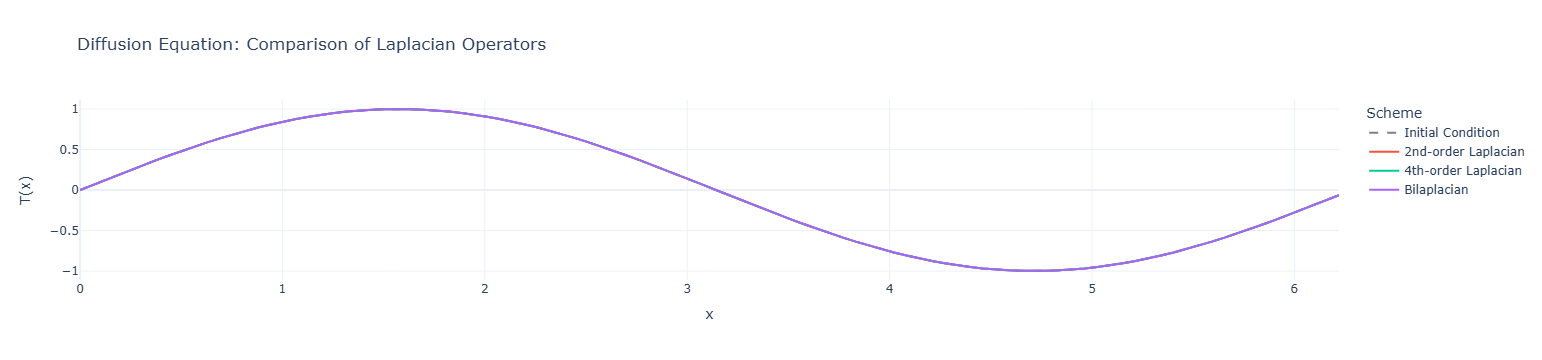

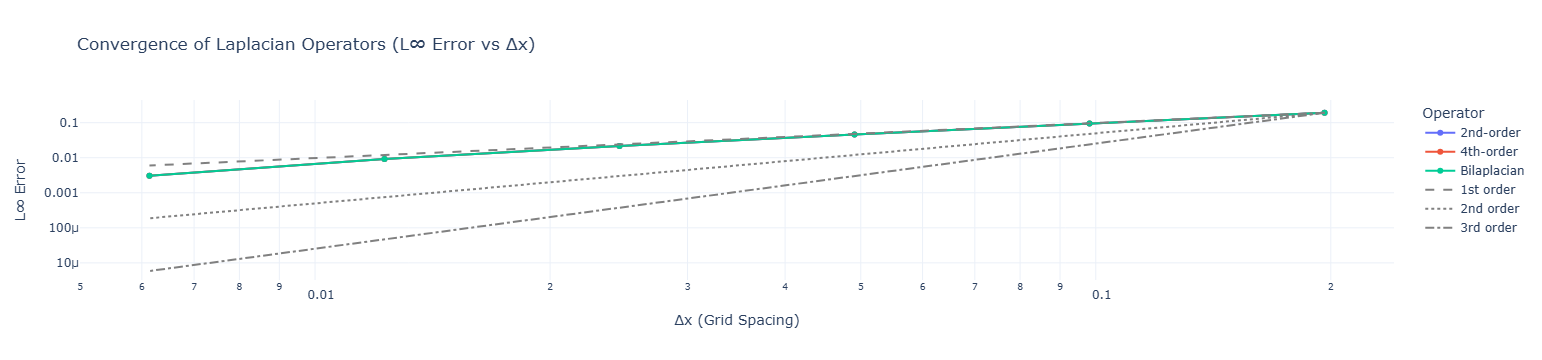

In [10]:
import numpy as np
import plotly.graph_objects as go

# --- Laplacian operators ---
def laplacian_2nd(T: np.ndarray, dx: float) -> np.ndarray:
    return (np.roll(T, -1) - 2 * T + np.roll(T, 1)) / dx**2

def laplacian_4th(T: np.ndarray, dx: float) -> np.ndarray:
    return (-np.roll(T, 2) + 16*np.roll(T, 1) - 30*T + 16*np.roll(T, -1) - np.roll(T, -2)) / (12 * dx**2)

def bilaplacian(T: np.ndarray, dx: float) -> np.ndarray:
    return laplacian_2nd(laplacian_2nd(T, dx), dx)

# --- Time stepping (Euler explicit) ---
def run_diffusion(T0: np.ndarray, laplacian_func, dx: float, dt: float, nt: int, nu: float) -> np.ndarray:
    T = T0.copy()
    for _ in range(nt):
        T += dt * nu * laplacian_func(T, dx)
    return T

# --- Initial condition ---
def initial_condition(x: np.ndarray) -> np.ndarray:
    return np.sin(x)

# --- Simulation configuration ---
L = 2 * np.pi
nx = 100
x = np.linspace(0, L, nx, endpoint=False)
dx = L / nx
dt = 1e-20
nt = 5000
nu = 1000

# --- Run simulations ---
T0 = initial_condition(x)
results = {
    "2nd-order Laplacian": run_diffusion(T0, laplacian_2nd, dx, dt, nt, nu),
    "4th-order Laplacian": run_diffusion(T0, laplacian_4th, dx, dt, nt, nu),
    "Bilaplacian": run_diffusion(T0, bilaplacian, dx, dt, nt, nu)
}

# --- Interactive Plotly figure ---
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=T0, mode='lines', name='Initial Condition', line=dict(dash='dash', color='gray')))

for name, T in results.items():
    fig.add_trace(go.Scatter(x=x, y=T, mode='lines', name=name))

fig.update_layout(
    title="Diffusion Equation: Comparison of Laplacian Operators",
    xaxis_title="x",
    yaxis_title="T(x)",
    legend_title="Scheme",
    template="plotly_white"
)
fig.show()

# --- Convergence study with L∞ error, now returns dx instead of number of points ---
def convergence_study_linf(laplacian_func, reference_nx=2048):
    resolutions = [32, 64, 128, 256, 512, 1024]
    errors = []

    # High-resolution reference
    x_ref = np.linspace(0, L, reference_nx, endpoint=False)
    dx_ref = L / reference_nx
    T0_ref = initial_condition(x_ref)
    T_ref = run_diffusion(T0_ref, laplacian_func, dx_ref, dt, nt, nu)

    for nx_coarse in resolutions:
        x_c = np.linspace(0, L, nx_coarse, endpoint=False)
        dx_c = L / nx_coarse
        T0_c = initial_condition(x_c)
        T_c = run_diffusion(T0_c, laplacian_func, dx_c, dt, nt, nu)

        # Interpolate coarse result to fine grid
        T_c_interp = np.interp(x_ref, x_c, T_c)
        error = np.max(np.abs(T_ref - T_c_interp))
        errors.append(error)

    dx_values = [L / nx for nx in resolutions]
    return dx_values, errors

# --- Compute convergence data ---
dx_2nd, err_2nd = convergence_study_linf(laplacian_2nd)
dx_4th, err_4th = convergence_study_linf(laplacian_4th)
dx_bilap, err_bilap = convergence_study_linf(bilaplacian)

# --- Plot convergence with respect to dx ---
fig_conv_linf = go.Figure()
fig_conv_linf.add_trace(go.Scatter(x=dx_2nd, y=err_2nd, mode='markers+lines', name='2nd-order'))
fig_conv_linf.add_trace(go.Scatter(x=dx_4th, y=err_4th, mode='markers+lines', name='4th-order'))
fig_conv_linf.add_trace(go.Scatter(x=dx_bilap, y=err_bilap, mode='markers+lines', name='Bilaplacian'))

# Reference slopes for visualization (choose a reference dx range)
ref_dx = np.array(dx_2nd)
# Scale factors chosen so lines align visually with data range
scale_1 = err_2nd[0] / (ref_dx[0] ** 1)
scale_2 = err_2nd[0] / (ref_dx[0] ** 2)
scale_3 = err_2nd[0] / (ref_dx[0] ** 3)

fig_conv_linf.add_trace(go.Scatter(
    x=ref_dx, y=scale_1 * ref_dx ** 1,
    mode='lines', name='1st order',
    line=dict(dash='dash', color='gray')
))
fig_conv_linf.add_trace(go.Scatter(
    x=ref_dx, y=scale_2 * ref_dx ** 2,
    mode='lines', name='2nd order',
    line=dict(dash='dot', color='gray')
))
fig_conv_linf.add_trace(go.Scatter(
    x=ref_dx, y=scale_3 * ref_dx ** 3,
    mode='lines', name='3rd order',
    line=dict(dash='dashdot', color='gray')
))

fig_conv_linf.update_layout(
    title="Convergence of Laplacian Operators (L∞ Error vs Δx)",
    xaxis=dict(title="Δx (Grid Spacing)", type="log"),
    yaxis=dict(title="L∞ Error", type="log"),
    legend_title="Operator",
    template="plotly_white"
)
fig_conv_linf.show()